In [1]:
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split

D:\Users\Alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torch
import torch.nn as nn
#from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models

import torchvision.transforms as transforms

In [3]:
from functions import(import_train_folder_dataset,
                      Data,
                      import_test_folder_dataset,
                      Data_test,
                      plot_loss_accuracy,
                      save_model,
                      save_metrics,
                      save_predictions_as_csv
                     )

# Variables

In [4]:
model_epochs = 100 # 100

lr = 0.006 # Learning rate.
                            
#torch.cuda.empty_cache()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


TRAIN_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8

checkpoints_save = 100 # Save after 50 epochs

model_checkpoints = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/CheckPoints/"
PATH = "D:\\Personal\\Alex\\Uni\\MS IA\\2 Curso\\Fall 2022\Artificial Intelligence\\Projects\\Project 1\\Models Save\\GoogleNet_CAM-Plus-ImgClass_v2\\"

# Path of the Data files
train_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Croped_v2/Train"
test_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Croped_v2/Test"

cuda


# Import Data

In [5]:

img_transform_val = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((400, 400)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


## Train-Val data

In [6]:
# Import the data
train_data, train_labels = import_train_folder_dataset(train_data_path)
print("Train Dim of Data: ", train_data.shape)
print("Train Dim of Lables: ", train_labels.shape)

Train Dim of Data:  (1149, 400, 400, 3)
Train Dim of Lables:  (1149,)


In [7]:
# Split into Train, Validation
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.1, random_state=1)
print("Dim of Data: ", X_train.shape)
print("Dim of Lables: ", y_train.shape)
print("Dim of X_test: ", X_val.shape)
print("Dim of y_test: ", y_val.shape)

Dim of Data:  (1034, 400, 400, 3)
Dim of Lables:  (1034,)
Dim of X_test:  (115, 400, 400, 3)
Dim of y_test:  (115,)


In [8]:
# Create the dataset object
train_Dataset = Data(X_train, y_train, img_transform_val) # img_transform
val_Dataset = Data(X_val, y_val, img_transform_val)

print("Train len: ",len(train_Dataset))
print("Val len: ",len(val_Dataset))

Train len:  1034
Val len:  115


In [9]:
# Create the dataloaders
train_loader = DataLoader(
    train_Dataset, 
    batch_size=TRAIN_BATCH_SIZE,             
    shuffle=True)

valid_loader = DataLoader(
    val_Dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
    )

## Test Data

In [10]:
# Import the data
test_data, test_names = import_test_folder_dataset(test_data_path)
print("Test Dim of Data: ", test_data.shape)
print("Test Dim of Lables: ", test_names.shape)

Test Dim of Data:  (380, 400, 400, 3)
Test Dim of Lables:  (380,)


In [11]:
# Create the dataset object
test_Dataset = Data_test(test_data, test_names, img_transform_val) # img_transform

print("Test len: ",len(test_Dataset))

Test len:  380


In [12]:
# Create the dataloaders
test_loader = DataLoader(
    test_Dataset, 
    batch_size=1,             
    shuffle=False)

# Create Model

In [13]:
#PyTorch - Building the Model
class ClassificationNet(nn.Module):
    def __init__(self, model):
        super(ClassificationNet, self).__init__()
        # get the pretrained googlenet network
        #self.googlenet = models.googlenet(pretrained=True)
        #self.resnet50 = models.resnet50(pretrained=True)
        
        # Get the feature extractor
        self.model_fe = nn.Sequential(*list(model.children())[:-1])
        #self.resnet50_fe = nn.Sequential(*list(self.resnet50.children())[:-1])
        
        # Flatten the FE output
        self.flatten = nn.Flatten()
        
        # Add a clissifier
        self.last_classifier =  nn.Linear(in_features=2048, out_features=4)
        
    def forward(self, x): 
        #x = self.resnet50_fe(x)
        x = self.model_fe(x)
        
        x = self.flatten(x)
        
        x = self.last_classifier(x)
        
        return x

modelpy = ClassificationNet(model = models.resnet50(pretrained=True)).to(device)

# Loss Function
criterion_2 = nn.CrossEntropyLoss()

# Optimizer    
trainable_parameters_2 = filter(lambda p: p.requires_grad, modelpy.parameters())
#optimizer_2 = torch.optim.Adam(params=trainable_parameters_2, lr=lr)
optimizer_2 = torch.optim.SGD(params=trainable_parameters_2, lr=lr, momentum=1e-5) 

# Check if checkpoint is available, if so, load it
model_epoch_m2_check = 0
previous_time = 0

modelpy

D:\Users\Alex\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
D:\Users\Alex\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ClassificationNet(
  (model_fe): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): 

In [14]:
# Check if checkpoint is available, if so, load it
model_epoch_m2_check = 0
previous_time = 0
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="model_ckpt_m2.pth"):
        print("Loading saved checkpoint")
        checkpoint = torch.load(model_checkpoints + "model_ckpt_m2.pth")
        modelpy.load_state_dict(checkpoint['model_state_dict'])
        modelpy.to(device)
        optimizer_2.load_state_dict(checkpoint['optimizer_state_dict'])
        model_epoch_m2_check = checkpoint['epoch']
        criterion_2 = checkpoint['loss']
        previous_time = checkpoint['time']
        print(f"Epoch of the checkpoint: {model_epoch_m2_check}")


In [15]:
# Model Parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Model Parameters: {count_parameters(modelpy)}")

Model Parameters: 23516228


# Train Model

In [16]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"]=lr

Epoch 1 of 100


100%|██████████| 15/15 [00:04<00:00,  3.18it/s]


train loss:  0.13208181011838194
Val loss:  0.12539872760358065
train accuracy:  0.534816247582205
Val accuracy:  0.5478260869565217
Best model at the moment with Val_acc 54.78, saving...
Current time: 3.718 minutes. Time expected till completion: 368.119 minutes
Epoch 2 of 100


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


train loss:  0.1184510781755761
Val loss:  0.12010222828906515
train accuracy:  0.59284332688588
Val accuracy:  0.5565217391304348
Best model at the moment with Val_acc 55.65, saving...
Current time: 5.624 minutes. Time expected till completion: 275.558 minutes
Epoch 3 of 100


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


train loss:  0.11485868461819175
Val loss:  0.115567393924879
train accuracy:  0.6102514506769826
Val accuracy:  0.5478260869565217
Current time: 7.514 minutes. Time expected till completion: 242.968 minutes
Epoch 4 of 100


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


train loss:  0.11265448733040166
Val loss:  0.11332595555678658
train accuracy:  0.6083172147001934
Val accuracy:  0.5478260869565217
Current time: 9.399 minutes. Time expected till completion: 225.578 minutes
Epoch 5 of 100


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


train loss:  0.10860377037087077
Val loss:  0.11236167316851409
train accuracy:  0.625725338491296
Val accuracy:  0.5478260869565217
Current time: 11.286 minutes. Time expected till completion: 214.434 minutes
Epoch 6 of 100


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


train loss:  0.10744522217970982
Val loss:  0.11219733124193938
train accuracy:  0.6218568665377177
Val accuracy:  0.5826086956521739
Best model at the moment with Val_acc 58.26, saving...
Current time: 13.185 minutes. Time expected till completion: 206.565 minutes
Epoch 7 of 100


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


train loss:  0.10253040417596496
Val loss:  0.10774896248527195
train accuracy:  0.6566731141199227
Val accuracy:  0.6260869565217392
Best model at the moment with Val_acc 62.61, saving...
Current time: 15.099 minutes. Time expected till completion: 200.597 minutes
Epoch 8 of 100


100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


train loss:  0.101574367031138
Val loss:  0.1099230706691742
train accuracy:  0.6528046421663443
Val accuracy:  0.591304347826087
Current time: 17.015 minutes. Time expected till completion: 195.676 minutes
Epoch 9 of 100


100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


train loss:  0.09878051044631973
Val loss:  0.1076239103856294
train accuracy:  0.6644100580270793
Val accuracy:  0.591304347826087
Current time: 18.913 minutes. Time expected till completion: 191.231 minutes
Epoch 10 of 100


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


train loss:  0.0986977145796357
Val loss:  0.10679405098376067
train accuracy:  0.6702127659574468
Val accuracy:  0.6260869565217392
Current time: 20.808 minutes. Time expected till completion: 187.272 minutes
Epoch 11 of 100


100%|██████████| 15/15 [00:04<00:00,  3.23it/s]


train loss:  0.09147528943748032
Val loss:  0.10668472155280735
train accuracy:  0.7030947775628626
Val accuracy:  0.591304347826087
Current time: 22.739 minutes. Time expected till completion: 183.981 minutes
Epoch 12 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  0.09316577294001957
Val loss:  0.10254083664520927
train accuracy:  0.6876208897485493
Val accuracy:  0.6
Current time: 24.679 minutes. Time expected till completion: 180.977 minutes
Epoch 13 of 100


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


train loss:  0.09115486654022445
Val loss:  0.11353038095909616
train accuracy:  0.706963249516441
Val accuracy:  0.6347826086956522
Best model at the moment with Val_acc 63.48, saving...
Current time: 26.638 minutes. Time expected till completion: 178.270 minutes
Epoch 14 of 100


100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


train loss:  0.08680173717223007
Val loss:  0.10757440199022708
train accuracy:  0.7166344294003868
Val accuracy:  0.6173913043478261
Current time: 28.612 minutes. Time expected till completion: 175.758 minutes
Epoch 15 of 100


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


train loss:  0.08857947092222292
Val loss:  0.10522599816322327
train accuracy:  0.706963249516441
Val accuracy:  0.6173913043478261
Current time: 30.544 minutes. Time expected till completion: 173.085 minutes
Epoch 16 of 100


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


train loss:  0.08293967557137893
Val loss:  0.10773883850678154
train accuracy:  0.7282398452611218
Val accuracy:  0.6434782608695652
Best model at the moment with Val_acc 64.35, saving...
Current time: 32.509 minutes. Time expected till completion: 170.674 minutes
Epoch 17 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  0.07707865309957379
Val loss:  0.09746876773626909
train accuracy:  0.7669245647969052
Val accuracy:  0.6347826086956522
Current time: 34.474 minutes. Time expected till completion: 168.315 minutes
Epoch 18 of 100


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


train loss:  0.07669643734940247
Val loss:  0.10072097830150438
train accuracy:  0.7591876208897486
Val accuracy:  0.6434782608695652
Current time: 36.447 minutes. Time expected till completion: 166.036 minutes
Epoch 19 of 100


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


train loss:  0.07256827555323016
Val loss:  0.11399594623109569
train accuracy:  0.7833655705996132
Val accuracy:  0.5739130434782609
Current time: 38.420 minutes. Time expected till completion: 163.791 minutes
Epoch 20 of 100


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


train loss:  0.07224807212385034
Val loss:  0.10726256033648615
train accuracy:  0.7882011605415861
Val accuracy:  0.6086956521739131
Current time: 40.372 minutes. Time expected till completion: 161.489 minutes
Epoch 21 of 100


100%|██████████| 15/15 [00:04<00:00,  3.33it/s]


train loss:  0.06838846385363684
Val loss:  0.1017090890718543
train accuracy:  0.776595744680851
Val accuracy:  0.6869565217391305
Best model at the moment with Val_acc 68.7, saving...
Current time: 42.321 minutes. Time expected till completion: 159.208 minutes
Epoch 22 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  0.06272448587809587
Val loss:  0.10945533695428268
train accuracy:  0.8249516441005803
Val accuracy:  0.591304347826087
Current time: 44.277 minutes. Time expected till completion: 156.982 minutes
Epoch 23 of 100


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


train loss:  0.06547824378400983
Val loss:  0.11262076289757439
train accuracy:  0.8181818181818182
Val accuracy:  0.6782608695652174
Current time: 46.236 minutes. Time expected till completion: 154.791 minutes
Epoch 24 of 100


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


train loss:  0.057401146256946735
Val loss:  0.11071766744489255
train accuracy:  0.8423597678916828
Val accuracy:  0.6434782608695652
Current time: 48.200 minutes. Time expected till completion: 152.634 minutes
Epoch 25 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  0.05855783363317844
Val loss:  0.11618697410044462
train accuracy:  0.8317214700193424
Val accuracy:  0.6695652173913044
Current time: 50.153 minutes. Time expected till completion: 150.459 minutes
Epoch 26 of 100


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


train loss:  0.04811173255917413
Val loss:  0.10844640498575957
train accuracy:  0.8829787234042553
Val accuracy:  0.6521739130434783
Current time: 52.118 minutes. Time expected till completion: 148.336 minutes
Epoch 27 of 100


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


train loss:  0.04596423740342
Val loss:  0.11735192951948746
train accuracy:  0.874274661508704
Val accuracy:  0.6347826086956522
Current time: 54.085 minutes. Time expected till completion: 146.230 minutes
Epoch 28 of 100


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


train loss:  0.04426902106006556
Val loss:  0.1128252853517947
train accuracy:  0.8868471953578336
Val accuracy:  0.7217391304347827
Best model at the moment with Val_acc 72.17, saving...
Current time: 56.051 minutes. Time expected till completion: 144.130 minutes
Epoch 29 of 100


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


train loss:  0.04406796962138071
Val loss:  0.11769464819327645
train accuracy:  0.8733075435203095
Val accuracy:  0.6521739130434783
Current time: 58.010 minutes. Time expected till completion: 142.025 minutes
Epoch 30 of 100


100%|██████████| 15/15 [00:04<00:00,  3.40it/s]


train loss:  0.03818602923743383
Val loss:  0.12941011281117148
train accuracy:  0.9100580270793037
Val accuracy:  0.6608695652173913
Current time: 59.989 minutes. Time expected till completion: 139.974 minutes
Epoch 31 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  0.036528000943146545
Val loss:  0.12296053689459095
train accuracy:  0.8945841392649904
Val accuracy:  0.6434782608695652
Current time: 61.954 minutes. Time expected till completion: 137.898 minutes
Epoch 32 of 100


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


train loss:  0.03546958773377094
Val loss:  0.12293882966041565
train accuracy:  0.9119922630560928
Val accuracy:  0.6521739130434783
Current time: 63.912 minutes. Time expected till completion: 135.812 minutes
Epoch 33 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  0.03372283305475629
Val loss:  0.13391370954720871
train accuracy:  0.9158607350096711
Val accuracy:  0.6347826086956522
Current time: 65.870 minutes. Time expected till completion: 133.735 minutes
Epoch 34 of 100


100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


train loss:  0.029103104026926903
Val loss:  0.13003099832845771
train accuracy:  0.9274661508704062
Val accuracy:  0.6695652173913044
Current time: 67.836 minutes. Time expected till completion: 131.681 minutes
Epoch 35 of 100


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


train loss:  0.029554796835670617
Val loss:  0.15614349362642868
train accuracy:  0.9361702127659575
Val accuracy:  0.6608695652173913
Current time: 69.812 minutes. Time expected till completion: 129.650 minutes
Epoch 36 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  0.026391571582199527
Val loss:  0.12172903975714808
train accuracy:  0.9352030947775629
Val accuracy:  0.7217391304347827
Current time: 71.766 minutes. Time expected till completion: 127.584 minutes
Epoch 37 of 100


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


train loss:  0.02537527952408076
Val loss:  0.14710405106129854
train accuracy:  0.9361702127659575
Val accuracy:  0.6434782608695652
Current time: 73.715 minutes. Time expected till completion: 125.514 minutes
Epoch 38 of 100


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


train loss:  0.024231021845536722
Val loss:  0.12940029087273971
train accuracy:  0.9303675048355899
Val accuracy:  0.6782608695652174
Current time: 75.686 minutes. Time expected till completion: 123.487 minutes
Epoch 39 of 100


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


train loss:  0.02337713941131904
Val loss:  0.12955282032489776
train accuracy:  0.9448742746615088
Val accuracy:  0.6695652173913044
Current time: 77.654 minutes. Time expected till completion: 121.458 minutes
Epoch 40 of 100


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


train loss:  0.024101186541000984
Val loss:  0.14329348958056906
train accuracy:  0.9361702127659575
Val accuracy:  0.6695652173913044
Current time: 79.621 minutes. Time expected till completion: 119.432 minutes
Epoch 41 of 100


100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


train loss:  0.02335958033205664
Val loss:  0.15646242991737697
train accuracy:  0.941972920696325
Val accuracy:  0.6521739130434783
Current time: 81.578 minutes. Time expected till completion: 117.393 minutes
Epoch 42 of 100


100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


train loss:  0.025068080314836778
Val loss:  0.13668465426434642
train accuracy:  0.9352030947775629
Val accuracy:  0.6782608695652174
Current time: 83.498 minutes. Time expected till completion: 115.307 minutes
Epoch 43 of 100


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


train loss:  0.017820189548458192
Val loss:  0.14530636467363522
train accuracy:  0.9545454545454546
Val accuracy:  0.6608695652173913
Current time: 85.412 minutes. Time expected till completion: 113.220 minutes
Epoch 44 of 100


100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


train loss:  0.0203211900942042
Val loss:  0.1597076707560083
train accuracy:  0.9535783365570599
Val accuracy:  0.6434782608695652
Current time: 87.330 minutes. Time expected till completion: 111.147 minutes
Epoch 45 of 100


100%|██████████| 15/15 [00:04<00:00,  3.40it/s]


train loss:  0.021375286614439475
Val loss:  0.1479002296924591
train accuracy:  0.9429400386847195
Val accuracy:  0.6521739130434783
Current time: 89.277 minutes. Time expected till completion: 109.116 minutes
Epoch 46 of 100


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


train loss:  0.015155743156349002
Val loss:  0.16179905611535778
train accuracy:  0.9661508704061895
Val accuracy:  0.6608695652173913
Current time: 91.228 minutes. Time expected till completion: 107.094 minutes
Epoch 47 of 100


100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


train loss:  0.01697292703616377
Val loss:  0.13760759843432385
train accuracy:  0.9584139264990329
Val accuracy:  0.6434782608695652
Current time: 93.197 minutes. Time expected till completion: 105.094 minutes
Epoch 48 of 100


100%|██████████| 15/15 [00:04<00:00,  3.36it/s]


train loss:  0.014544534128352033
Val loss:  0.15031404391579006
train accuracy:  0.9729206963249516
Val accuracy:  0.6434782608695652
Current time: 95.192 minutes. Time expected till completion: 103.124 minutes
Epoch 49 of 100


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


train loss:  0.016752590312725166
Val loss:  0.20932505078937697
train accuracy:  0.9593810444874274
Val accuracy:  0.5826086956521739
Current time: 97.150 minutes. Time expected till completion: 101.115 minutes
Epoch 50 of 100


100%|██████████| 15/15 [00:04<00:00,  3.26it/s]


train loss:  0.015722083565292654
Val loss:  0.15425912556440935
train accuracy:  0.9622823984526112
Val accuracy:  0.591304347826087
Current time: 99.161 minutes. Time expected till completion: 99.161 minutes
Epoch 51 of 100


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


train loss:  0.015451792370873851
Val loss:  0.14457109304873839
train accuracy:  0.9632495164410058
Val accuracy:  0.6782608695652174
Current time: 101.126 minutes. Time expected till completion: 97.160 minutes
Epoch 52 of 100


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


train loss:  0.014024071912398305
Val loss:  0.15266264534514884
train accuracy:  0.965183752417795
Val accuracy:  0.6608695652173913
Current time: 103.154 minutes. Time expected till completion: 95.219 minutes
Epoch 53 of 100


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


train loss:  0.01745604123511285
Val loss:  0.16450424608976943
train accuracy:  0.9574468085106383
Val accuracy:  0.6521739130434783
Current time: 105.127 minutes. Time expected till completion: 93.226 minutes
Epoch 54 of 100


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


train loss:  0.015886967604515113
Val loss:  0.16758215712464375
train accuracy:  0.9642166344294004
Val accuracy:  0.6521739130434783
Current time: 107.094 minutes. Time expected till completion: 91.228 minutes
Epoch 55 of 100


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


train loss:  0.012600316982437106
Val loss:  0.18200355560883233
train accuracy:  0.971953578336557
Val accuracy:  0.6173913043478261
Current time: 109.058 minutes. Time expected till completion: 89.229 minutes
Epoch 56 of 100


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


train loss:  0.011701766836792015
Val loss:  0.16131670837816986
train accuracy:  0.9709864603481625
Val accuracy:  0.6521739130434783
Current time: 111.042 minutes. Time expected till completion: 87.247 minutes
Epoch 57 of 100


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


train loss:  0.010558243452506482
Val loss:  0.17231810792632726
train accuracy:  0.9777562862669246
Val accuracy:  0.6260869565217392
Current time: 113.043 minutes. Time expected till completion: 85.278 minutes
Epoch 58 of 100


100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


train loss:  0.010298976701471731
Val loss:  0.199902232185654
train accuracy:  0.9816247582205029
Val accuracy:  0.6260869565217392
Current time: 115.026 minutes. Time expected till completion: 83.295 minutes
Epoch 59 of 100


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


train loss:  0.008804334363944259
Val loss:  0.17034419787966687
train accuracy:  0.9835589941972921
Val accuracy:  0.6608695652173913
Current time: 117.018 minutes. Time expected till completion: 81.318 minutes
Epoch 60 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  0.013992475248905659
Val loss:  0.25711090253747027
train accuracy:  0.9709864603481625
Val accuracy:  0.6347826086956522
Current time: 119.002 minutes. Time expected till completion: 79.334 minutes
Epoch 61 of 100


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


train loss:  0.010539509271356192
Val loss:  0.16455768767906273
train accuracy:  0.971953578336557
Val accuracy:  0.7043478260869566
Current time: 120.976 minutes. Time expected till completion: 77.346 minutes
Epoch 62 of 100


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


train loss:  0.01228706386278976
Val loss:  0.16419427174588908
train accuracy:  0.9700193423597679
Val accuracy:  0.6782608695652174
Current time: 122.958 minutes. Time expected till completion: 75.361 minutes
Epoch 63 of 100


100%|██████████| 15/15 [00:04<00:00,  3.32it/s]


train loss:  0.012946230659983706
Val loss:  0.16597113842549532
train accuracy:  0.9758220502901354
Val accuracy:  0.6434782608695652
Current time: 124.938 minutes. Time expected till completion: 73.377 minutes
Epoch 64 of 100


100%|██████████| 15/15 [00:04<00:00,  3.40it/s]


train loss:  0.008703216376698197
Val loss:  0.18295718016831772
train accuracy:  0.9816247582205029
Val accuracy:  0.6260869565217392
Current time: 126.918 minutes. Time expected till completion: 71.391 minutes
Epoch 65 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  0.009574502473471892
Val loss:  0.16932095859361732
train accuracy:  0.97678916827853
Val accuracy:  0.6347826086956522
Current time: 128.888 minutes. Time expected till completion: 69.401 minutes
Epoch 66 of 100


100%|██████████| 15/15 [00:04<00:00,  3.28it/s]


train loss:  0.011910645317104313
Val loss:  0.1789714937624724
train accuracy:  0.9758220502901354
Val accuracy:  0.6260869565217392
Current time: 130.870 minutes. Time expected till completion: 67.418 minutes
Epoch 67 of 100


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


train loss:  0.009713875748486415
Val loss:  0.19714447415393332
train accuracy:  0.9825918762088974
Val accuracy:  0.6608695652173913
Current time: 132.862 minutes. Time expected till completion: 65.440 minutes
Epoch 68 of 100


100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


train loss:  0.01223939102921253
Val loss:  0.20102194716101107
train accuracy:  0.9738878143133463
Val accuracy:  0.6086956521739131
Current time: 134.843 minutes. Time expected till completion: 63.456 minutes
Epoch 69 of 100


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


train loss:  0.009424061798607674
Val loss:  0.18005290109178293
train accuracy:  0.9806576402321083
Val accuracy:  0.5826086956521739
Current time: 136.830 minutes. Time expected till completion: 61.475 minutes
Epoch 70 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  0.01022992908224604
Val loss:  0.18177365906860518
train accuracy:  0.9787234042553191
Val accuracy:  0.5739130434782609
Current time: 138.799 minutes. Time expected till completion: 59.485 minutes
Epoch 71 of 100


100%|██████████| 15/15 [00:04<00:00,  3.32it/s]


train loss:  0.008564078261196699
Val loss:  0.20680485264114712
train accuracy:  0.9845261121856866
Val accuracy:  0.6173913043478261
Current time: 140.788 minutes. Time expected till completion: 57.505 minutes
Epoch 72 of 100


100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


train loss:  0.009126591800268005
Val loss:  0.16796814177347266
train accuracy:  0.9816247582205029
Val accuracy:  0.6173913043478261
Current time: 142.773 minutes. Time expected till completion: 55.523 minutes
Epoch 73 of 100


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


train loss:  0.010378194812548345
Val loss:  0.1938747411188872
train accuracy:  0.9777562862669246
Val accuracy:  0.6
Current time: 144.771 minutes. Time expected till completion: 53.546 minutes
Epoch 74 of 100


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


train loss:  0.008676861680781097
Val loss:  0.1590253000026164
train accuracy:  0.9835589941972921
Val accuracy:  0.6521739130434783
Current time: 146.733 minutes. Time expected till completion: 51.555 minutes
Epoch 75 of 100


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


train loss:  0.007751296699606423
Val loss:  0.1520546452506729
train accuracy:  0.9835589941972921
Val accuracy:  0.6956521739130435
Current time: 148.692 minutes. Time expected till completion: 49.564 minutes
Epoch 76 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  0.006427189405256346
Val loss:  0.2814001404720804
train accuracy:  0.9893617021276596
Val accuracy:  0.5217391304347826
Current time: 150.641 minutes. Time expected till completion: 47.571 minutes
Epoch 77 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  0.014363716277982896
Val loss:  0.17349280902872916
train accuracy:  0.9690522243713733
Val accuracy:  0.6608695652173913
Current time: 152.588 minutes. Time expected till completion: 45.578 minutes
Epoch 78 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  0.009237457747027148
Val loss:  0.17560443748598514
train accuracy:  0.9796905222437138
Val accuracy:  0.6434782608695652
Current time: 154.545 minutes. Time expected till completion: 43.590 minutes
Epoch 79 of 100


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


train loss:  0.008382478923666538
Val loss:  0.17994405575420547
train accuracy:  0.9854932301740812
Val accuracy:  0.6695652173913044
Current time: 156.500 minutes. Time expected till completion: 41.601 minutes
Epoch 80 of 100


100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


train loss:  0.008145970421189324
Val loss:  0.19130531445793483
train accuracy:  0.9864603481624759
Val accuracy:  0.5652173913043478
Current time: 158.457 minutes. Time expected till completion: 39.614 minutes
Epoch 81 of 100


100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


train loss:  0.0070340032784972605
Val loss:  0.20218923221463742
train accuracy:  0.9835589941972921
Val accuracy:  0.6434782608695652
Current time: 160.404 minutes. Time expected till completion: 37.626 minutes
Epoch 82 of 100


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


train loss:  0.006264144652460051
Val loss:  0.23911137399466142
train accuracy:  0.9912959381044487
Val accuracy:  0.6782608695652174
Current time: 162.364 minutes. Time expected till completion: 35.641 minutes
Epoch 83 of 100


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


train loss:  0.017044054102008474
Val loss:  0.1875275177800137
train accuracy:  0.9671179883945842
Val accuracy:  0.6260869565217392
Current time: 164.352 minutes. Time expected till completion: 33.663 minutes
Epoch 84 of 100


100%|██████████| 15/15 [00:04<00:00,  3.32it/s]


train loss:  0.008126967325937219
Val loss:  0.18137680719728055
train accuracy:  0.9854932301740812
Val accuracy:  0.6782608695652174
Current time: 166.342 minutes. Time expected till completion: 31.684 minutes
Epoch 85 of 100


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


train loss:  0.008271017010959596
Val loss:  0.18917910009622574
train accuracy:  0.9835589941972921
Val accuracy:  0.6260869565217392
Current time: 168.306 minutes. Time expected till completion: 29.701 minutes
Epoch 86 of 100


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


train loss:  0.008087474634943843
Val loss:  0.2067503521947757
train accuracy:  0.9864603481624759
Val accuracy:  0.6608695652173913
Current time: 170.277 minutes. Time expected till completion: 27.719 minutes
Epoch 87 of 100


100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


train loss:  0.008235928195963724
Val loss:  0.1765061899371769
train accuracy:  0.9835589941972921
Val accuracy:  0.6347826086956522
Current time: 172.267 minutes. Time expected till completion: 25.741 minutes
Epoch 88 of 100


100%|██████████| 15/15 [00:04<00:00,  3.46it/s]


train loss:  0.009292897496307611
Val loss:  0.18533119118731955
train accuracy:  0.9806576402321083
Val accuracy:  0.6173913043478261
Current time: 174.252 minutes. Time expected till completion: 23.762 minutes
Epoch 89 of 100


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


train loss:  0.005526223141232567
Val loss:  0.17186216025248818
train accuracy:  0.9893617021276596
Val accuracy:  0.6434782608695652
Current time: 176.281 minutes. Time expected till completion: 21.787 minutes
Epoch 90 of 100


100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


train loss:  0.006561737300815039
Val loss:  0.18561265727748041
train accuracy:  0.988394584139265
Val accuracy:  0.6173913043478261
Current time: 178.277 minutes. Time expected till completion: 19.809 minutes
Epoch 91 of 100


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


train loss:  0.006338982761180482
Val loss:  0.21250377426976744
train accuracy:  0.9893617021276596
Val accuracy:  0.6347826086956522
Current time: 180.268 minutes. Time expected till completion: 17.829 minutes
Epoch 92 of 100


100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


train loss:  0.004427265655744741
Val loss:  0.1889231659795927
train accuracy:  0.9912959381044487
Val accuracy:  0.6347826086956522
Current time: 182.670 minutes. Time expected till completion: 15.884 minutes
Epoch 93 of 100


100%|██████████| 15/15 [00:04<00:00,  3.31it/s]


train loss:  0.005533090175448771
Val loss:  0.19327051853356153
train accuracy:  0.988394584139265
Val accuracy:  0.6608695652173913
Current time: 184.587 minutes. Time expected till completion: 13.894 minutes
Epoch 94 of 100


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


train loss:  0.007534013735997352
Val loss:  0.20786730724832286
train accuracy:  0.988394584139265
Val accuracy:  0.6608695652173913
Current time: 186.580 minutes. Time expected till completion: 11.909 minutes
Epoch 95 of 100


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


train loss:  0.004811038030930696
Val loss:  0.18884776804758155
train accuracy:  0.9932301740812379
Val accuracy:  0.6086956521739131
Current time: 188.582 minutes. Time expected till completion: 9.925 minutes
Epoch 96 of 100


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


train loss:  0.007845599937076614
Val loss:  0.17599210619278577
train accuracy:  0.9758220502901354
Val accuracy:  0.6608695652173913
Current time: 190.583 minutes. Time expected till completion: 7.941 minutes
Epoch 97 of 100


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


train loss:  0.0042153854113129805
Val loss:  0.1992949436540189
train accuracy:  0.9932301740812379
Val accuracy:  0.6347826086956522
Current time: 192.591 minutes. Time expected till completion: 5.956 minutes
Epoch 98 of 100


100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


train loss:  0.004595184997901792
Val loss:  0.1878508939691212
train accuracy:  0.995164410058027
Val accuracy:  0.6260869565217392
Current time: 194.642 minutes. Time expected till completion: 3.972 minutes
Epoch 99 of 100


100%|██████████| 15/15 [00:04<00:00,  3.13it/s]


train loss:  0.00869775400570201
Val loss:  0.2450339376926422
train accuracy:  0.9748549323017408
Val accuracy:  0.5739130434782609
Current time: 196.679 minutes. Time expected till completion: 1.987 minutes
Epoch 100 of 100


100%|██████████| 15/15 [00:05<00:00,  2.93it/s]


train loss:  0.00514589233807607
Val loss:  0.20153182777373688
train accuracy:  0.988394584139265
Val accuracy:  0.6695652173913044
Saving model 2 checkpoint


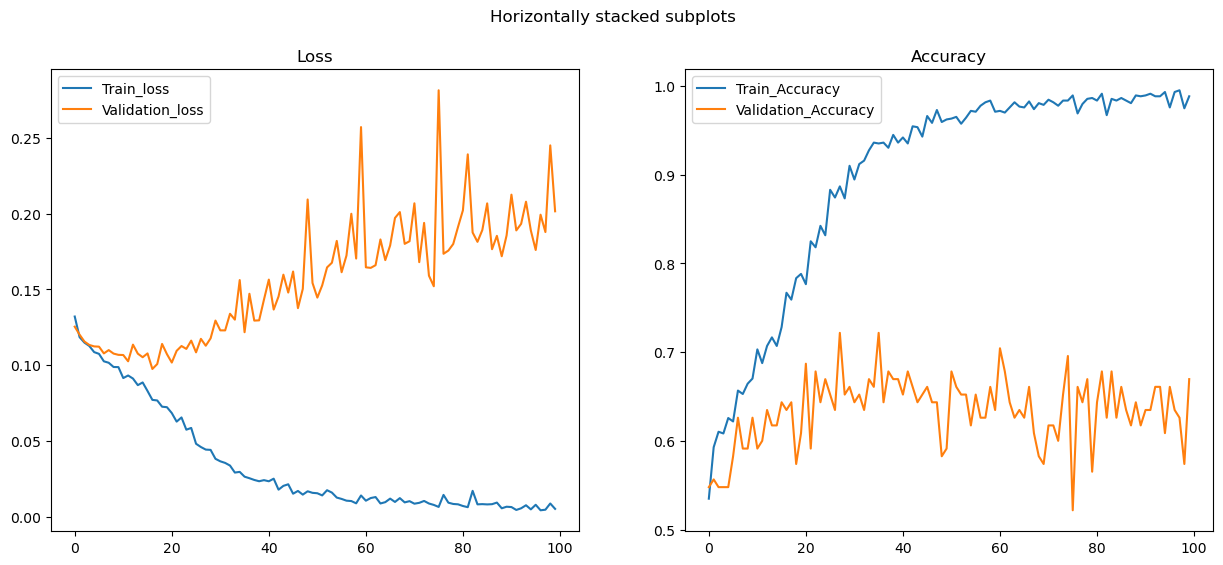

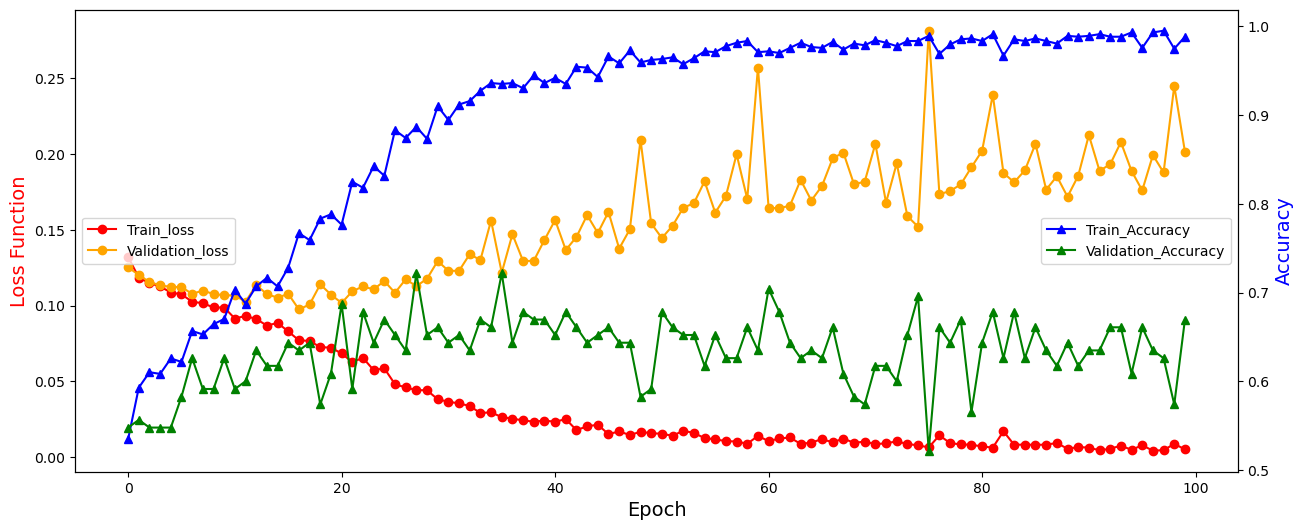

Current time: 199.435 minutes. Time expected till completion: 0.000 minutes
Finished training in: 199.438 minutes


In [17]:

best_model_val_acc = -1

train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

# Load checkpoints
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="metrics_losss_accuracy_m2.csv"):
        print("Loading Metrics")
        dd = pd.read_csv(model_checkpoints + "metrics_losss_accuracy_m2.csv")
        train_loss = dd["train_loss"].tolist()
        val_loss = dd["val_loss"].tolist()
        train_accuracy = dd["train_accuracy"].tolist()
        val_accuracy = dd["val_accuracy"].tolist()

# count time
start = time.time()
for epoch in range(model_epoch_m2_check, model_epochs):
    # Print current epoch
    print(f"Epoch {epoch + 1} of {model_epochs}")
    
    if(epoch%10 == 0):
        update_optimizer(optimizer_2, 0.001)
        
    ############################################################################
    ################################ Train model ############################### 
    ############################################################################
    modelpy.train()
    running_loss=0
    total=0
    correct=0
    # loop for every training batch (one epoch)
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)): # use tqdm package to track running time
        
        # Get the tensors
        images = data[0].to(device)# use the gpu
        labels = data[1].to(device)# use the gpu
        
        # Optimize second model
        
        #create the output from the CNN base on the give batch images
        out_m2 = modelpy(images)
        # count the loss function 
        loss_2 = criterion_2(out_m2, labels)    
        
        # BackPropagate on model 2
        ######################
        optimizer_2.zero_grad()
        ######################
        # count the backpropagation
        loss_2.backward()
        # learning
        optimizer_2.step()
        
        
        
        # add new value to the main loss
        running_loss += loss_2.item()
        
        # calculate accuracy
        predictions = torch.argmax(out_m2, dim=1)
        total += labels.size(0)
        correct +=(predictions == labels).sum().item()
        
        
    train_epoch_loss = running_loss/len(train_loader.dataset)
    
    train_epoch_accuracy = correct/total
    
    ############################################################################
    ################################ Eval model ################################ 
    ############################################################################
    modelpy.eval()
    running_loss = 0.0
    correct=0
    total=0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            # Get the tensors
            images = data[0].to(device)# use the gpu
            label = data[1].to(device)# use the gpu
            
            #create the output from the CNN base on the give batch images
            outputs = modelpy(images)
            # count the loss function
            loss = criterion_2(outputs, label)
            
            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            
            # calculate accuracy
            predictions = torch.argmax(outputs, dim=1)
            total += label.size(0)
            correct +=(predictions == label).sum().item()
            
    val_epoch_loss = running_loss/len(valid_loader.dataset) 
    val_epoch_accuracy = correct/total
    
    
    print("train loss: ", train_epoch_loss)
    print("Val loss: ", val_epoch_loss)
    print("train accuracy: ", train_epoch_accuracy)
    print("Val accuracy: ", val_epoch_accuracy)

    
    # save results
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_accuracy.append(val_epoch_accuracy)
    
    # Save best model
    if(best_model_val_acc < val_epoch_accuracy):
        print(f"Best model at the moment with Val_acc {round(val_epoch_accuracy*100,2)}, saving...")
        # Save Model
        bestmodel_name = "model_2_bestModel.pt"
        torch.save(modelpy, PATH+bestmodel_name)
        best_model_val_acc = val_epoch_accuracy
    
    # Save model with all information every 100 epochs. Can be used 
    # resuming training. optim
    if (epoch+1) % checkpoints_save == 0: # checkpoints_save
        
        end = time.time()
        time_elapsed = (end-start)+previous_time
        
        # Save Model
        print("Saving model 2 checkpoint")
        save_model(epoch, time_elapsed, modelpy, optimizer_2, criterion_2, path = model_checkpoints + "model_ckpt_m2.pth")
        # save the metrics
        save_metrics(train_loss, val_loss, train_accuracy, val_accuracy, path = model_checkpoints + "metrics_losss_accuracy_m2.csv")
        
        # save model at epoch
        save_model(epoch, time_elapsed, modelpy, optimizer_2, criterion_2, path = model_checkpoints + "model_ckpt_m2_"+str(epoch+1)+".pth")
        
        
        # Check the evolution at this point
        plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)
        
        
    ep_time = time.time()
    print(f"Current time: {(((ep_time-start)+previous_time)/60):.3f} minutes. Time expected till completion: {(((((ep_time-start)+previous_time)/(epoch + 1)) * (model_epochs-(epoch + 1)))/60):.3f} minutes")
    
end = time.time()
print(f"Finished training in: {(((end-start)+previous_time)/60):.3f} minutes") 

In [18]:
best_model_val_acc

0.7217391304347827

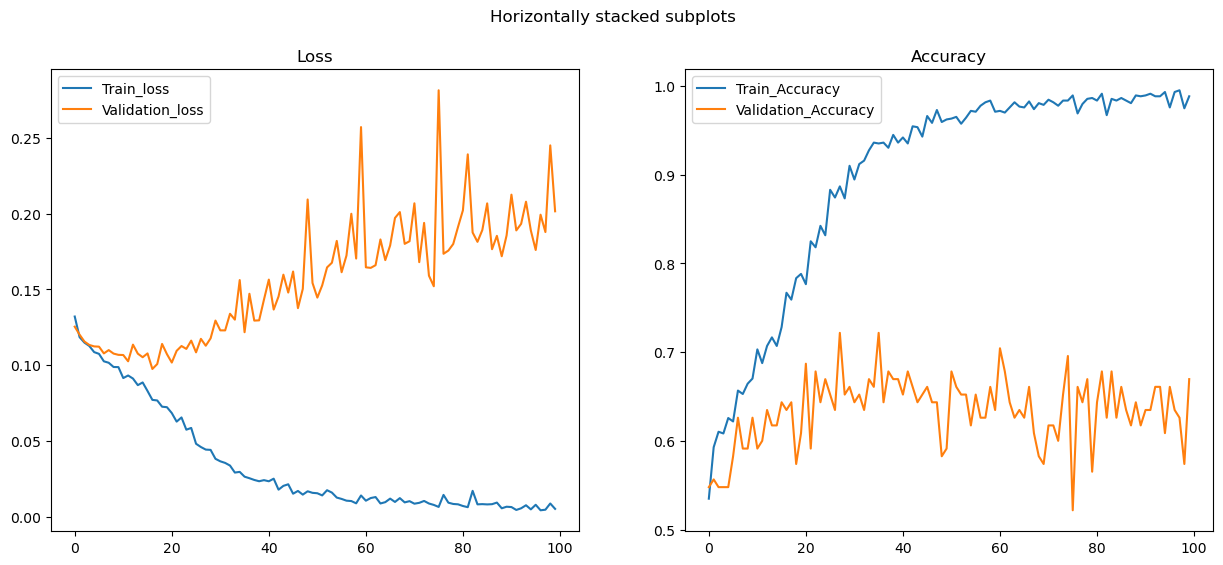

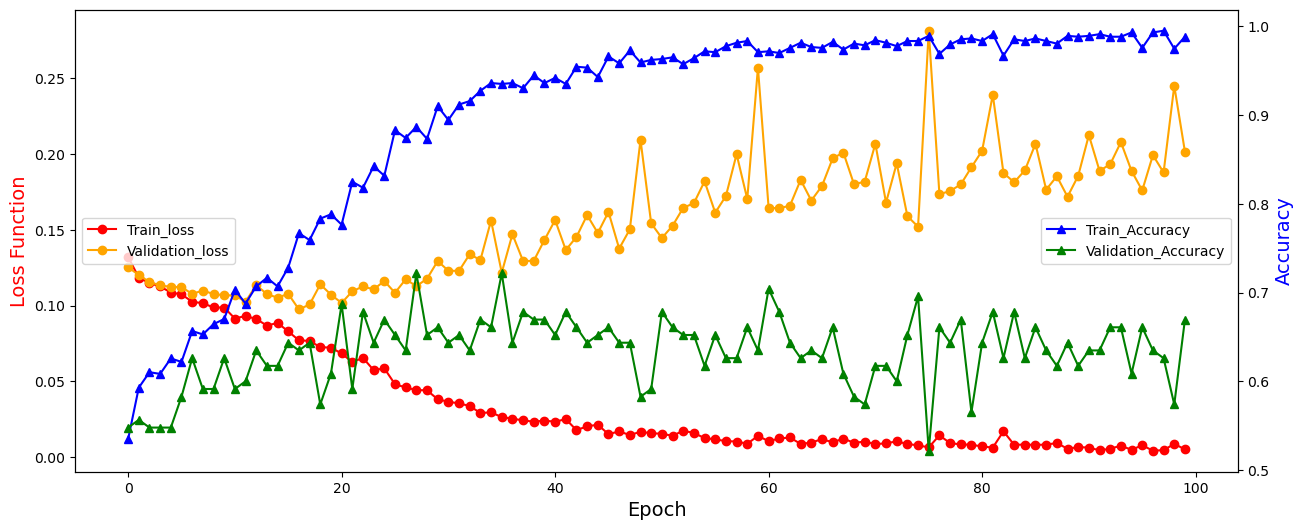

In [19]:
plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)

## Save model

In [20]:
# Save Model
NAME2 = "model_2.pt"

torch.save(modelpy, PATH+NAME2)

# Load Last Model

In [21]:
# Load the model
NAME = "model_2.pt"
modelpy = torch.load(PATH+NAME, map_location=device)
modelpy.eval()

ClassificationNet(
  (model_fe): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): 

## Evaluate Last Model

In [22]:
def accuracy_given_set(mm2, valid_loader, device, name="Validation"):
    # Evaluate the Validation Set
    mm2.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            new_images = data[0].to(device)

            outputs = mm2(new_images)
            predictions = torch.argmax(outputs, dim=1)

            total += data[1].size(0)
            correct +=(predictions == data[1].to(device)).sum().item()
        
    print(f'Accuracy of the network on the {total} {name} instances: {100 * correct / total}%')

In [23]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy, train_loader, device, name="Train")
accuracy_given_set(modelpy, valid_loader, device, name="Validation")

100%|██████████| 130/130 [00:38<00:00,  3.41it/s]


Accuracy of the network on the 1034 Train instances: 99.90328820116054%


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]

Accuracy of the network on the 115 Validation instances: 66.95652173913044%


## Test Predictions Last Model

In [24]:
def make_predictions(mm2, loader, device):
    # Evaluate the Validation Set
    mm2.eval()
    predictions_list = []
    name_list = []
    
    with torch.no_grad():
        for bi, data in tqdm(enumerate(loader), total=len(loader)):
            new_images = data[0].to(device)
        
            outputs = mm2(new_images)
            predictions = torch.argmax(outputs, dim=1)
        
            predictions_list.append(predictions[0].item())
            name_list.append(data[1][0])
        
    return(predictions_list, name_list)

In [25]:
pred, names = make_predictions(modelpy, test_loader, device)

np.unique(np.array(pred),return_counts=True)

100%|██████████| 380/380 [00:23<00:00, 15.93it/s]


(array([0, 1, 2, 3]), array([165, 148,  64,   3], dtype=int64))

In [26]:
save_predictions_as_csv(names, pred, name="GGCv2_plus_clas_v01_ResNet_prediction.csv")

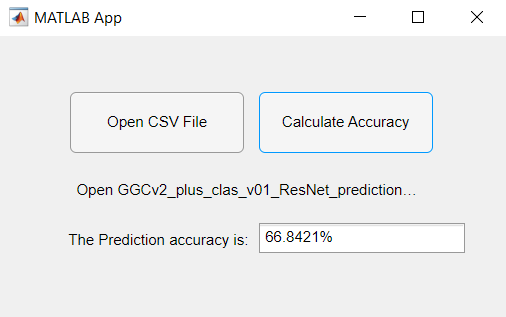

# Load Best Model

In [27]:
# Load the model
NAME = "model_2_bestModel.pt"
modelpy_bestModel = torch.load(PATH+NAME, map_location=device)
modelpy_bestModel.eval()

ClassificationNet(
  (model_fe): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): 

## Evaluate Best Model

In [28]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy_bestModel, train_loader, device, name="Train")
accuracy_given_set(modelpy_bestModel, valid_loader, device, name="Validation")

100%|██████████| 130/130 [00:38<00:00,  3.38it/s]


Accuracy of the network on the 1034 Train instances: 94.77756286266924%


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]

Accuracy of the network on the 115 Validation instances: 72.17391304347827%


## Test Predictions Best Model

In [29]:
pred, names = make_predictions(modelpy_bestModel, test_loader, device)

np.unique(np.array(pred),return_counts=True)

100%|██████████| 380/380 [00:18<00:00, 20.23it/s]


(array([0, 1, 2]), array([166, 134,  80], dtype=int64))

In [30]:
save_predictions_as_csv(names, pred, name="GGCv2_plus_clas_v01_ResNet_best_prediction.csv")

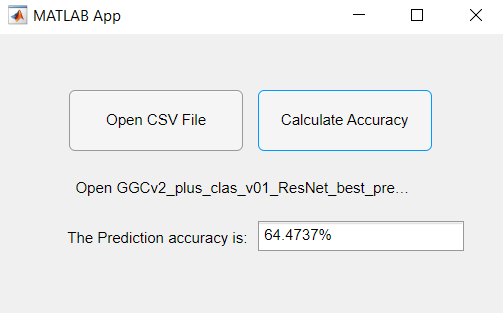